# That stupid wooden Puzzle

## Imports

In [1]:
from matplotlib import pyplot as plt
from typing import List
import numpy as np
import itertools
from functools import lru_cache
import matplotlib.colors as mcolors
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import display

## Logic

### Possible Moves

In [2]:
@lru_cache(128)
def get_all_directions(nb_dims = 2):
    return np.concatenate([np.eye(nb_dims), -np.eye(nb_dims)]).astype(int)

def get_new_direction(old_direction, rotation):
    nb_dims = len(old_direction) - 1
    was_passive = np.array(old_direction) == 0
    out = np.zeros_like(old_direction)
    out[was_passive] = get_all_directions()[rotation % (nb_dims * 2)]
    return list(out)

def get_points(structure, rotation):
    points = [np.array([0,0,0])]
    current_direction = [1,0,0]
    for bend, rot in zip(structure, rotation):
        if bend:
            current_direction = get_new_direction(current_direction, rot)
        points.append(points[-1] + current_direction)
    return points - np.min(points, axis=0)

### Solved Criteria

In [3]:
def is_in_extent(points, nb_dims = 3):
    points = points - np.min(points, axis = 0)
    extent = 3*[nb_dims]
    return [all(p < extent) for p in points]

def is_solved(structure, rotation, n = 3):
    points = get_points(structure, rotation)
    in_extent = is_in_extent(points)
    return len(points[in_extent]) == n**3

### Visualization

In [4]:
def str_to_arr(s:str):
    return [int(x) for x in s]

def plot_cube(pos, ax, color='r', alpha = .5, extent = (3,3,3)):
    colors = [*mcolors.to_rgb(color), alpha]
    indices = np.indices(extent+1) + .5
    cube = np.logical_and.reduce([ind == p+.5 for p, ind in zip(pos, indices)])
    ax.voxels(cube, facecolors=colors, edgecolor='gray', alpha=alpha)

def plot_snake(structure: str, rotation: str, show_cubes : bool = True, color_wrong=True,
              show_string: bool = True, cube_alpha : float = 0.5, step = 27,
              elev = 30, azim=30):
    structure, rotation = str_to_arr(structure), str_to_arr(rotation)
    points = get_points(structure, rotation)
    is_in_ext = is_in_extent(points)
            
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize = (9,9))
    ax = fig.add_subplot(111, projection='3d')
    if show_cubes:
        extent = np.max(points, axis=0)
        for i, point, in_ext in zip(range(step), points, is_in_ext):
            color = 'peru' if i%2 == 1 else 'darkslategray'
            if not in_ext and color_wrong:
                color='r'
            plot_cube(point, ax, color = color, alpha = cube_alpha, extent=extent)
    if show_string:
        ax.plot(*np.array(points[:step]).T + .5, lw = 5, c='gray')
    ax.view_init(elev, azim)
    plt.show()

## Basic Structure

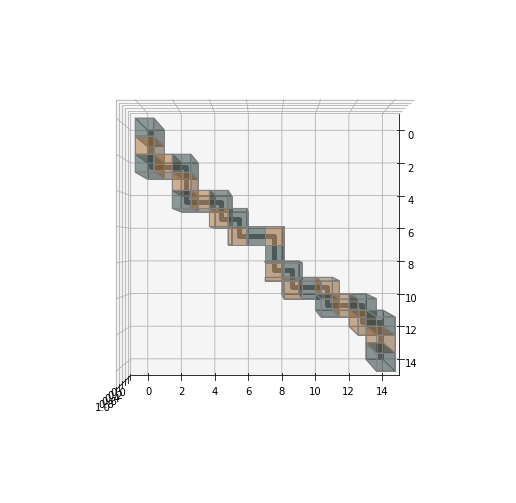

In [5]:
structure = str_to_arr('00101010111101011101101110')
rotation = str_to_arr('00000000000000000000000000')

plot_snake(structure, rotation, cube_alpha=0.3, color_wrong=False, azim=0, elev=90)

## Interactive Visualization

In [6]:
%matplotlib inline

structure = '00101010111101011101101110'
rotation = '00002030010202001030'

play = widgets.Play(value=27, min=0, max=30, step=1, interval = 500)
play_slider = widgets.IntSlider(max=50)
elev_slider = widgets.IntSlider(value = 30, min = 0, max = 360, orientation='vertical')
azim_slider = widgets.IntSlider(value = 30, min = 0, max = 360)
structure_inp = widgets.Text(value='00101010111101011101101110')
rotation_inp = widgets.Text(value='000020300102020010')
show_cubes_cbox = widgets.Checkbox(value=True)
show_string_cbox = widgets.Checkbox(value=True)
alpha_slider = widgets.FloatSlider(value=0.5, min=0, max=1)

interactive_plot = interactive(plot_snake, structure = structure_inp, rotation = rotation_inp, 
                               show_cubes=show_cubes_cbox,
                               show_string = show_string_cbox, step = play_slider,
                               cube_alpha = alpha_slider, azim = azim_slider,
                              elev = elev_slider)

widgets.jslink((play, 'value'), (play_slider, 'value'))
play_box = widgets.HBox([play, play_slider])
plot_box = widgets.VBox([widgets.HBox([interactive_plot.children[-1], elev_slider]), azim_slider])
texts_box = widgets.HBox([rotation_inp, structure_inp])
plot_controls = widgets.HBox([show_cubes_cbox, show_string_cbox, alpha_slider])

output = interactive_plot.children[-1]
output.layout.height = '500px'
display(texts_box, plot_controls, play_box, plot_box)